For fully rendered notebook please visit this direct link https://nbviewer.jupyter.org/github/Cybernorse/WA-jupyter-notebooks/blob/main/web%20traffic%20forcasting.ipynb  

predicting unique visitors for this website http://statforecasting.com/ which we have visitor traffic dataset of.

Dataset and data description can be found at:
https://www.kaggle.com/bobnau/daily-website-visitors

In [1]:
import numpy as np 
import pandas as pd
import pandas_profiling
import warnings
warnings.filterwarnings('ignore')
import datetime
from datetime import date

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

# import chart_studio.plotly as py
import cufflinks as cf
import plotly.express as px

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

cf.go_offline()

import pandas_profiling
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import xgboost as xg
# from prophet import Prophet

Importing the required dataset, renaming the columns, removing the commas from the columns and converting their 
data types 

In [2]:
df=pd.read_csv('../input/daily-website-visitors/daily-website-visitors.csv')

df.rename(columns = {'Day.Of.Week':'day_of_week'
                    ,'Page.Loads':'page_loads'
                    ,'Unique.Visits':'unique_visits'
                    ,'First.Time.Visits':'first_visits'
                    ,'Returning.Visits':'returning_visits'}, inplace = True)

df=df.replace(',','',regex=True)

df['page_loads']=df['page_loads'].astype(int)
df['unique_visits']=df['unique_visits'].astype(int)
df['first_visits']=df['first_visits'].astype(int)
df['returning_visits']=df['returning_visits'].astype(int)

df

Row        Day  day_of_week       Date  page_loads  unique_visits  \
0        1     Sunday            1  9/14/2014        2146           1582   
1        2     Monday            2  9/15/2014        3621           2528   
2        3    Tuesday            3  9/16/2014        3698           2630   
3        4  Wednesday            4  9/17/2014        3667           2614   
4        5   Thursday            5  9/18/2014        3316           2366   
...    ...        ...          ...        ...         ...            ...   
2162  2163   Saturday            7  8/15/2020        2221           1696   
2163  2164     Sunday            1  8/16/2020        2724           2037   
2164  2165     Monday            2  8/17/2020        3456           2638   
2165  2166    Tuesday            3  8/18/2020        3581           2683   
2166  2167  Wednesday            4  8/19/2020        2064           1564   

      first_visits  returning_visits  
0             1430               152  
1             2297               231  
2             2352               278  
3             2327               287  
4             2130               236  
...            ...               ...  
2162          1373               323  
2163          1686               351  
2164          2181               457  
2165          2184               499  
2166          1297               267  

[2167 rows x 8 columns]

Checking for the null values if any

In [3]:
df.isna().sum()

Row                 0
Day                 0
day_of_week         0
Date                0
page_loads          0
unique_visits       0
first_visits        0
returning_visits    0
dtype: int64

Checking for duplicate values if any

In [4]:
df.duplicated().sum()

0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Row               2167 non-null   int64 
 1   Day               2167 non-null   object
 2   day_of_week       2167 non-null   int64 
 3   Date              2167 non-null   object
 4   page_loads        2167 non-null   int64 
 5   unique_visits     2167 non-null   int64 
 6   first_visits      2167 non-null   int64 
 7   returning_visits  2167 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 135.6+ KB


generating line plot for visualizing the trend of page loads and visits over time series, it seems that page loads and visits have a constant fluctuation, means they have trend over time and are correlated to each other.

In [6]:
px.line(df,x='Date',y=['page_loads' ,'unique_visits' ,'first_visits' ,'returning_visits'],
       labels={'value':'Visits'}
       ,title='Page Loads & visitors over Time')

This histogram plot represent the sum of unique visits for each day in the week against count of unique visits for each day in the week.

but from this plot it's hard to estimate which day had the most unique visitors, so we will explore more deeper.

In [7]:
px.histogram(df,x='unique_visits',color='Day',title='unique visits for each day')

With this bar plot it is clear that tuesday, wednesday, monday and thursday are the days in a week when extensive amount of traffic come to this website  

In [8]:
day_imp=df.groupby(['Day'])['unique_visits'].agg(['sum']).sort_values(by='sum',ascending=False)
px.bar(day_imp,labels={'value':'sum of unique visits'},title='Sum of Unique visits for each day')

sum of unique visits for each week day over time series, we know which days get the most traffic but on what time intervals ? this graph answers to that question.

time intervals are grouped according to their relation with unique visits and days, now we can understand that in  which days, months and years did the website get the most traffic. 

In [9]:
px.histogram(df,x='Date',y='unique_visits',color='Day',title='Sum of unique visits for each day over Time')

get the sum of page_loads 	unique_visits 	first_visits 	returning_visits related to each of their days

In [10]:
sums=df.groupby(['Day'])[['page_loads' ,'unique_visits' ,'first_visits' ,'returning_visits']].sum().sort_values(
    by='unique_visits',ascending=False)
sums

page_loads  unique_visits  first_visits  returning_visits
Day                                                                 
Tuesday       1536154        1097181        907752            189429
Wednesday     1517114        1085624        897602            188022
Monday        1502161        1072112        886036            186076
Thursday      1437269        1028214        848921            179293
Friday        1149437         817852        668805            149047
Sunday        1006564         725794        604198            121596
Saturday       772817         552105        456449             95656

this grouped bar chart comes from the crosstab above and it shows the sum of page_loads, unique_visits, first_visits, returning_visits for each day 

In [11]:
px.bar(sums,barmode='group',title='Sum of page loads and visits for each of their days')

This is a heatmap graph that shows the correlation of each datapoint from page_loads, unique_visits, first_visits , returning_visits columns, first visits seems to have a great correlation with unique visits.

The Yellow points indicate a great correlation between first visits and unique visits, but we don't how much let's find that out

In [12]:
px.density_heatmap(df, x='Date',y=['page_loads' ,'unique_visits' ,'first_visits' ,'returning_visits']
#                    color_continuous_scale="Viridis"
                   ,marginal_x="histogram", marginal_y="histogram",title='Correlation for each data point')

this shows the paired correlation of page_loads 	unique_visits 	first_visits 	returning_visits columns with annotated values we know that first visits and unique visits are correlated by 0.99 which is a great correlation and page loads have a good correlation with our target variable as well.

let's see how the correlation looks like in our next plot.

<AxesSubplot:>

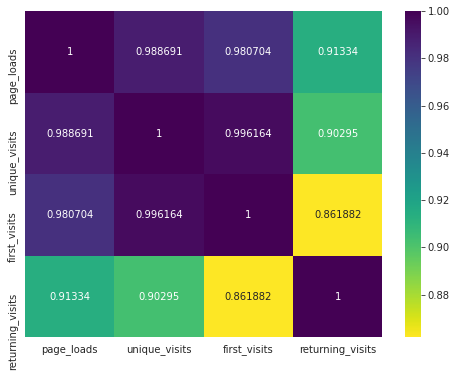

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
sns.heatmap(df[['page_loads' ,'unique_visits' ,'first_visits' ,'returning_visits']].corr(),
            annot=True,
            cmap='viridis_r', 
            fmt='g')

this scatter matrix plot shows the paired plot of page_loads 	unique_visits 	first_visits 	returning_visits we can see that unique visits and first visits have a straight upward line, that means that first visits are increasing as the unique visits increase. we can also other pairs and identify their level of correlation visualy.

The last thing we need is to visualize the trend line.

In [14]:
px.scatter_matrix(df[['page_loads' ,'unique_visits' ,'first_visits' ,'returning_visits']])

Okay now we have the regression line pointing upward which confirms the trend between these two columns

In [15]:
px.scatter(
    df, x='first_visits', y='unique_visits',opacity=0.4,
    trendline='ols', trendline_color_override='purple',title="Regression line for unique visits and first visits"
)

there are no outliears that need to be dealt with, data is tightly packed with no dispersion except for returning visits, this column was also less correlated with our target variable.  

In [16]:
px.violin(df,y=['page_loads' ,'unique_visits' ,'first_visits' ,'returning_visits'],box=True,points='all')

starting the feature engineering.

we only need these columns 

In [17]:
pred_df=df[['page_loads' ,'unique_visits' ,'first_visits' ,'returning_visits','Day']]

Tuesday, wednesday, thursday and monday are the days when our website received the most traffic so we will create a feature days_f of them 1 value will define their existence and 0 will define the rest of the days.

In [18]:
pred_df['days_f']=np.where((df['Day']=='Tuesday') | 
                      (df['Day']=='Wednesday') | 
                      (df['Day']=='Thursday') |
                      (df['Day']=='Monday'),1,0)

pred_df

page_loads  unique_visits  first_visits  returning_visits        Day  \
0           2146           1582          1430               152     Sunday   
1           3621           2528          2297               231     Monday   
2           3698           2630          2352               278    Tuesday   
3           3667           2614          2327               287  Wednesday   
4           3316           2366          2130               236   Thursday   
...          ...            ...           ...               ...        ...   
2162        2221           1696          1373               323   Saturday   
2163        2724           2037          1686               351     Sunday   
2164        3456           2638          2181               457     Monday   
2165        3581           2683          2184               499    Tuesday   
2166        2064           1564          1297               267  Wednesday   

      days_f  
0          0  
1          1  
2          1  
3          1  
4          1  
...      ...  
2162       0  
2163       0  
2164       1  
2165       1  
2166       1  

[2167 rows x 6 columns]

Multi Linear Regression model

In [19]:
pred_df.drop('Day',axis=1,inplace=True)
# drop the days column as we don't need it anymore

In [20]:
pred_df.head(5)

page_loads  unique_visits  first_visits  returning_visits  days_f
0        2146           1582          1430               152       0
1        3621           2528          2297               231       1
2        3698           2630          2352               278       1
3        3667           2614          2327               287       1
4        3316           2366          2130               236       1

separate the independent variable and dependent / target variable 

In [21]:
X2=pred_df[['page_loads','first_visits' ,'returning_visits','days_f']]
y2=pred_df['unique_visits']

split the dataset in train and test samples now

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3,random_state=42)

train the model with train sample

In [23]:
regressor2 = LinearRegression(fit_intercept=False,normalize=True)
regressor2.fit(X_train, y_train)

LinearRegression(fit_intercept=False, normalize=True)

In [24]:
y_pred2 = regressor2.predict(X_test)

In [25]:
lr2 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred2})
lr2

Actual  Predicted
1486    4173     4173.0
1602    1902     1902.0
1460    2870     2870.0
1134    2142     2142.0
1513    4329     4329.0
...      ...        ...
439     2579     2579.0
271     2494     2494.0
244     1818     1818.0
1159    3332     3332.0
1701    2565     2565.0

[651 rows x 2 columns]

visualize the actual and predicted values

<AxesSubplot:>

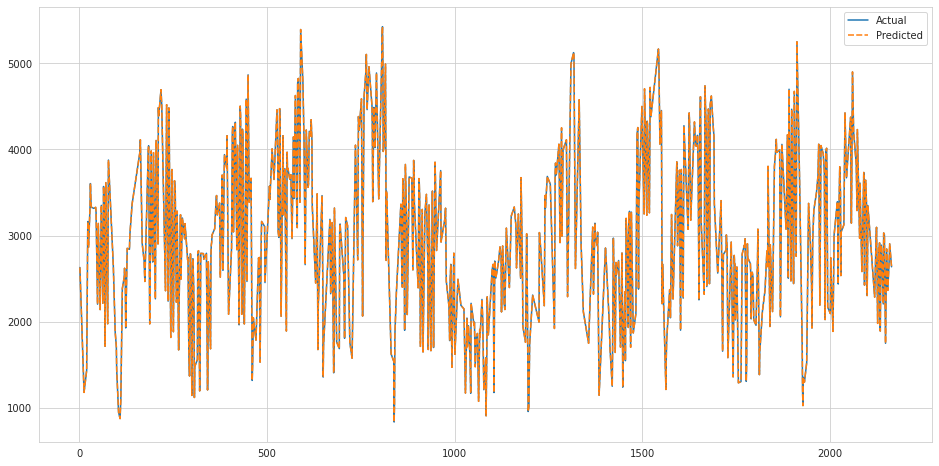

In [26]:
plt.figure(figsize=(16,8))
sns.lineplot(data=lr2)

get the accuacy score of the model.

In [27]:
regressor2.score(X_test,y_test)*100

100.0

Support Vector Regression

In [28]:
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.00001)
svr_rbf.fit(X_train, y_train)

SVR(C=1000.0, gamma=1e-05)

In [29]:
y_pred3 = svr_rbf.predict(X_test)

In [30]:
svr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred3})
svr

Actual    Predicted
1486    4173  4173.783532
1602    1902  1904.847560
1460    2870  2870.181094
1134    2142  2142.904123
1513    4329  4328.316673
...      ...          ...
439     2579  2578.897313
271     2494  2493.887467
244     1818  1816.932763
1159    3332  3331.902324
1701    2565  2564.972314

[651 rows x 2 columns]

<AxesSubplot:>

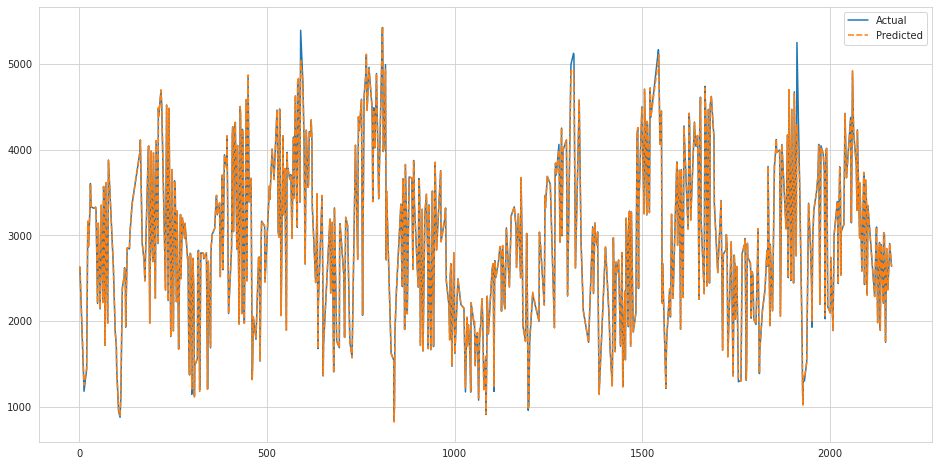

In [31]:
plt.figure(figsize=(16,8))
sns.lineplot(data=svr)

In [32]:
svr_rbf.score(X_test,y_test)*100

99.80054455767926

Decision Tree Regression

In [33]:
dtr = DecisionTreeRegressor(random_state=0)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [34]:
dtr_pred = dtr.predict(X_test)

In [35]:
dtr_g = pd.DataFrame({'Actual': y_test, 'Predicted': dtr_pred})
dtr_g

Actual  Predicted
1486    4173     4140.0
1602    1902     1929.0
1460    2870     2871.0
1134    2142     2198.0
1513    4329     4330.0
...      ...        ...
439     2579     2572.0
271     2494     2518.0
244     1818     1826.0
1159    3332     3341.0
1701    2565     2559.0

[651 rows x 2 columns]

<AxesSubplot:>

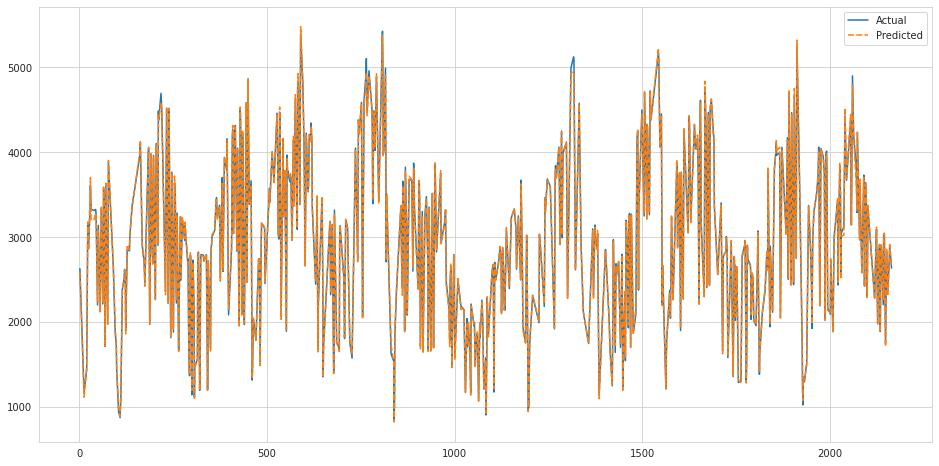

In [36]:
plt.figure(figsize=(16,8))
sns.lineplot(data=dtr_g)

In [37]:
dtr.score(X_test,y_test)*100

99.85504139672305

XGboost regression

In [38]:
xgb_r = xg.XGBRegressor(objective ='reg:squarederror',n_estimators = 10, seed = 123)
xgb_r.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=4, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [39]:
xgb_pred = xgb_r.predict(X_test)

In [40]:
xgb_df = pd.DataFrame({'Actual': y_test, 'Predicted': xgb_pred})
xgb_df

Actual    Predicted
1486    4173  4069.691895
1602    1902  1860.709961
1460    2870  2798.565430
1134    2142  2050.101318
1513    4329  4167.435547
...      ...          ...
439     2579  2427.022705
271     2494  2415.062012
244     1818  1780.136475
1159    3332  3223.888916
1701    2565  2459.920410

[651 rows x 2 columns]

<AxesSubplot:>

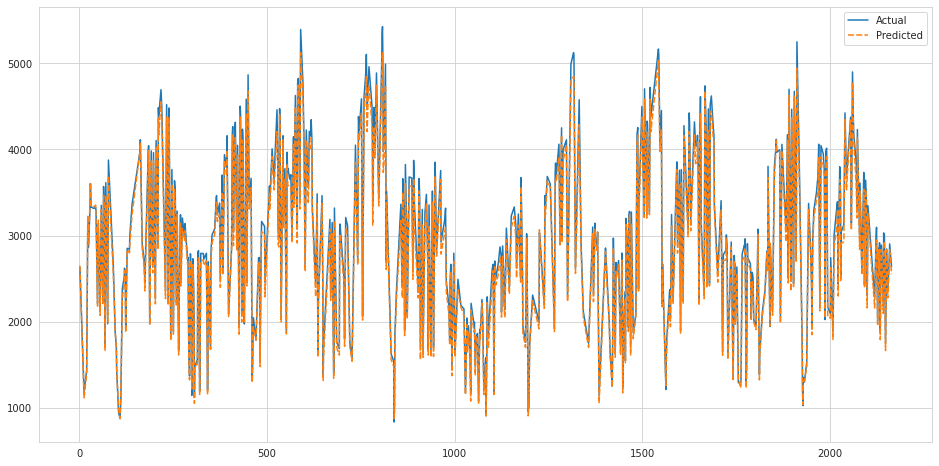

In [41]:
plt.figure(figsize=(16,8))
sns.lineplot(data=xgb_df)

In [42]:
xgb_r.score(X_test,y_test)*100

98.7655882096893